In [177]:
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
num_cpu = 8
clientCPU = [0,1,2,3]
serverCPU = [4,5,6,7]
idle_times={}
for i in range(num_cpu):
    idle_times[i]=[]
    
outputfolder = "output"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
with open(utilFile) as f:
    utilBigList = f.read().split("@")[1:]


for utilSingle in utilBigList:
    idle_times_temp = {}
    for i in range(num_cpu):
        idle_times_temp[i]=[]
    stringNewLine = utilSingle.split('\n')[2:]
    for stringLine in stringNewLine:        
        words = stringLine.split()
        if(len(words)>=2 and words[2].isdigit()):
            if(words[0] is "Average:"):
                print("Average")
                continue
            CPU = int(words[2])
            idle = float(words[-1].rstrip('\x00'))
#             print(CPU)
#             print(idle)
            idle_times_temp[CPU].append(idle)
    for i in range(num_cpu):
        idle_times[i].append(idle_times_temp[i])
idle_times_avg = {}
for i in range(num_cpu):
    idle_times_avg[i]=[]
    for times in idle_times[i]:
        idle_times_avg[i].append(np.mean(times))
#print(idle_times_avg)

with open(operationsFile) as f:                                                                                                                                                                                     
    operationsStr = f.read().split('\n')[:-1]
operations = np.array(map(int, operationsStr))

def readBenchmark(benchmarkFile):
    readLatency95 = []
    updateLatency95 = []
    readLatency99 = []
    updateLatency99 = []
    readLatencyAvg = []
    updateLatencyAvg = []
    readOperations = []
    updateOperations = []
    throughput = []
    with open(benchmarkFile) as f:
        lines = f.readlines()
        for line in lines:
    #         print(line)
            if re.search('\[READ\]\, 95thPercentileLatency\(us\)', line, re.I):
                readLatency95.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 95thPercentileLatency\(us\)', line, re.I):
                updateLatency95.append(float(line.split()[2]))
            if re.search('\[READ\]\, 99thPercentileLatency\(us\)', line, re.I):
                readLatency99.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 99thPercentileLatency\(us\)', line, re.I):
                updateLatency99.append(float(line.split()[2]))
            if re.search('\[READ\], Operations',line, re.I):
                readOperations.append(float(line.split()[2]))
            if re.search('\[UPDATE\], Operations',line, re.I):
                updateOperations.append(float(line.split()[2]))
            if re.search('\[OVERALL\], Throughput',line, re.I):
                throughput.append(float(line.split()[2]))
            if re.search('\[UPDATE\], AverageLatency\(us\)',line, re.I):
                updateLatencyAvg.append(float(line.split()[2]))
            if re.search('\[READ\], AverageLatency\(us\)',line, re.I):
                readLatencyAvg.append(float(line.split()[2]))
            
    readLatency99 = np.array(readLatency99)
    updateLatency99 = np.array(updateLatency99)
    throughput = np.array(throughput)
    return {
        "readLatency95":readLatency95,
        "updateLatency95":updateLatency95,
        "readLatency99":readLatency99,
        "updateLatency99":updateLatency99,
        "readOperations":readOperations,
        "updateOperations":updateOperations,
        "updateLatencyAvg":updateLatencyAvg,
        "readLatencyAvg":readLatencyAvg,
        "throughput":throughput
        
           
    }



for cpu in idle_times_avg:
    idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
# idle_times_avg = np.array(idle_times_avg)?
# print(idle_times_avg[0])
   




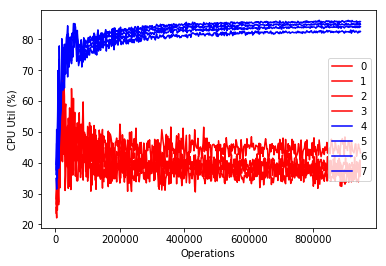

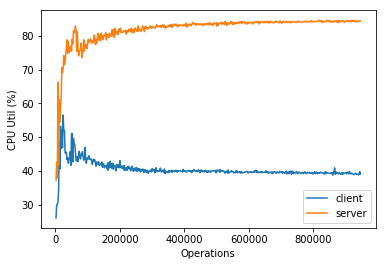

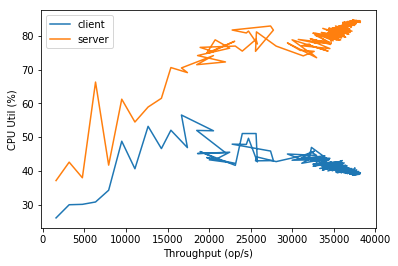

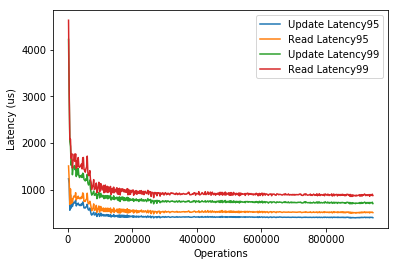

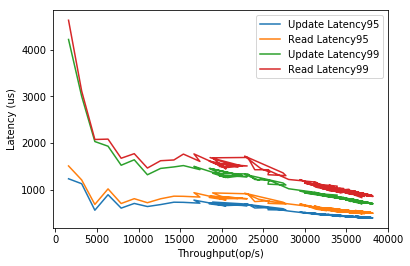

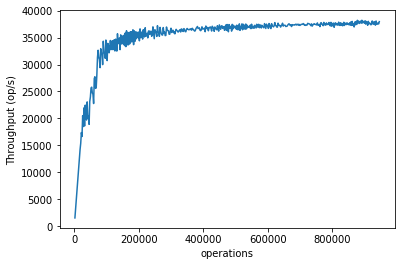

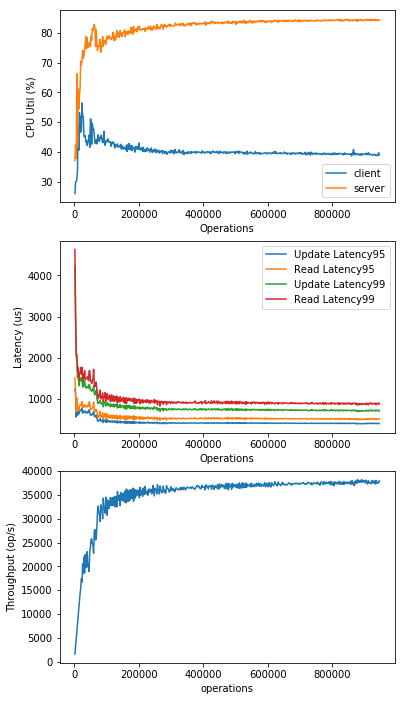

In [178]:
bench1 = readBenchmark(benchmarkFile)
#bench1 = readBenchmark("output/benchmark2.txt")
for i in idle_times_avg:
    idle_times_avg[i]=idle_times_avg[i][0:len(bench1["throughput"])]
operations = operations[:len(bench1["throughput"])]
util_bench = idle_times_avg[0]*0
util_server = idle_times_avg[0]*0
for i in range(num_cpu):
    if i in clientCPU:
        util_bench = util_bench + idle_times_avg[i]
    elif i in serverCPU:
        util_server = util_server + idle_times_avg[i]
util_bench = 100.0 - util_bench/len(clientCPU)
util_server = 100.0 - util_server/(len(serverCPU))
# readLatency = bench1["readLatency"]
plt.figure(1)

for i in range(num_cpu):
    if(i in clientCPU):
        plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='red')
        continue
    elif(i in serverCPU):
        plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='blue')
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(2)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
plt.show()

plt.figure(2)
plt.plot(bench1["throughput"],util_bench,label="client")
plt.plot(bench1["throughput"],util_server,label="server")
plt.legend()
plt.xlabel("Throughput (op/s)")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(3)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
plt.savefig("latency.png")
plt.show()


plt.figure(3)
plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Throughput(op/s)")
plt.ylabel("Latency (us)")
plt.savefig("throughput.png")
plt.show()

plt.figure()
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
# plt.savefig("throughput.png")
plt.show()

# plt.figure(4)
# plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
# plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")

# plt.legend()
# plt.show()


# plt.figure(4)
# plt.plot(operations[:len(readOperations)],np.array(operations[:len(readOperations)])-(np.array(readOperations)+np.array(updateOperations)))
# plt.show()
fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*3))
plt.subplot(3,1,1)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
# plt.show()


plt.subplot(3,1,2)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
# plt.savefig("latency.png")
# plt.show()

plt.subplot(3,1,3)
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
plt.savefig("graphs.png")
plt.show()

In [179]:
bench1["readLatency99"]

array([ 4631.,  3113.,  2075.,  2083.,  1673.,  1771.,  1463.,  1620.,
        1636.,  1762.,  1605.,  1766.,  1457.,  1612.,  1486.,  1688.,
        1506.,  1476.,  1499.,  1508.,  1549.,  1443.,  1682.,  1690.,
        1427.,  1427.,  1374.,  1450.,  1484.,  1719.,  1359.,  1300.,
        1320.,  1408.,  1218.,  1161.,  1002.,  1055.,  1101.,  1215.,
        1000.,  1016.,  1054.,  1142.,   935.,  1019.,  1069.,  1158.,
         953.,   973.,  1129.,  1075.,   990.,  1044.,  1092.,   932.,
        1035.,  1099.,   945.,  1043.,  1072.,   938.,  1059.,  1024.,
         953.,  1069.,   898.,  1004.,  1027.,   932.,  1054.,   935.,
         982.,  1008.,   952.,  1041.,   905.,  1015.,   900.,  1029.,
         887.,  1010.,   962.,  1020.,   972.,  1008.,   951.,  1000.,
         947.,   989.,   942.,  1022.,   890.,  1007.,   895.,   983.,
         900.,   985.,   949.,   962.,   996.,   880.,   966.,   910.,
         973.,   980.,   900.,   965.,   949.,   920.,   975.,   915.,
      

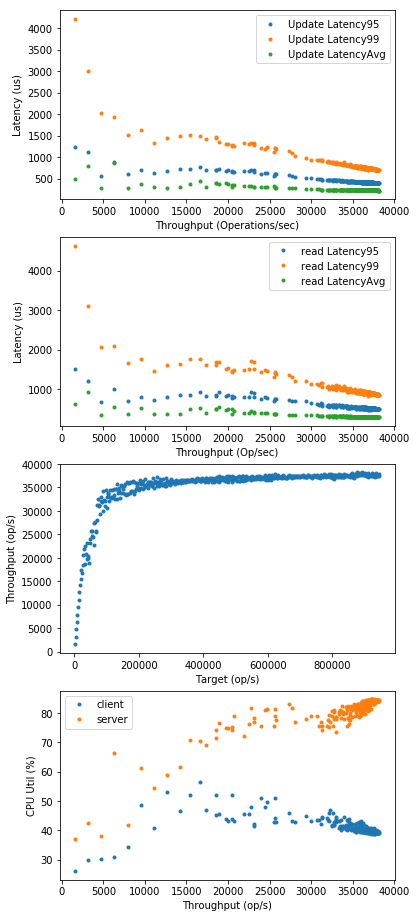

In [181]:
fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.plot(bench1["throughput"][0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95",linestyle='None',marker=".")

plt.plot(bench1["throughput"][0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99",linestyle='None',marker=".")
plt.plot(bench1["throughput"][0:len(bench1["updateLatency99"])],bench1["updateLatencyAvg"],label="Update LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Throughput (Operations/sec)")
plt.ylabel("Latency (us)")
plt.legend()

plt.subplot(4,1,2)
plt.plot(bench1["throughput"][0:len(bench1["readLatency95"])],bench1["readLatency95"],label="read Latency95",linestyle='None',marker=".")

plt.plot(bench1["throughput"][0:len(bench1["readLatency99"])],bench1["readLatency99"],label="read Latency99",linestyle='None',marker=".")
plt.plot(bench1["throughput"][0:len(bench1["readLatency99"])],bench1["readLatencyAvg"],label="read LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Throughput (Op/sec)")
plt.ylabel("Latency (us)")
plt.legend()


plt.subplot(4,1,3)
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"],linestyle='None',marker=".")
plt.xlabel("Target (op/s)")
plt.ylabel("Throughput (op/s)")


plt.subplot(4,1,4)
plt.plot(bench1["throughput"],util_bench,label="client",linestyle='None',marker=".")
plt.plot(bench1["throughput"],util_server,label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Throughput (op/s)")
plt.ylabel("CPU Util (%)")
plt.savefig("New_plot_target_throughput_pretty.png")
plt.show()


# plt.ylim(ymax=10000)

In [175]:
bench1["readLatency99"]

array([ 3617.,  4431.,  4041.,  5535.,  3041.,  4119.,  3507.,  2831.,
        1977.,  2837.,  2927.,  2807.,  2487.,  1839.,  1835.,  2036.,
        1773.,  1656.,  1730.,  1704.,  1918.,  1961.,  3607.,  2467.,
        2683.,  2707.,  2921.,  1985.,  2109.,  2075.,  1631.,  1376.,
        1316.,  1334.,  1288.,  1202.,  1035.,  1066.,  1114.,  1275.,
        1033.])

In [176]:
bench1["updateLatency99"]

array([ 2959.,  4235.,  3741.,  5543.,  2781.,  3821.,  3319.,  2563.,
        1837.,  2551.,  2635.,  2443.,  2363.,  1664.,  1652.,  1744.,
        1566.,  1420.,  1441.,  1420.,  1597.,  1634.,  3043.,  2039.,
        2437.,  2435.,  2575.,  1680.,  1810.,  1656.,  1377.,  1164.,
        1121.,  1140.,  1064.,   997.,   904.,   918.,   949.,  1021.,
         903.])